In [26]:
import multiprocessing
import json

import numpy as np
import pandas as pd

import tensorflow as tf

import ray
from ray import tune

from matplotlib import pyplot as plt
import seaborn as sns

import gym

n_cpus = multiprocessing.cpu_count()
n_cpus

8

In [2]:
n_gpus = len(tf.config.list_physical_devices('GPU'))
n_gpus

0

In [3]:
# initialize ray
# https://ray.readthedocs.io/en/latest/package-ref.html#ray.init
ray.init(ignore_reinit_error=True, log_to_driver=False, webui_host='0.0.0.0')


2020-02-24 08:12:17,850	INFO resource_spec.py:212 -- Starting Ray with 0.93 GiB memory available for workers and up to 0.49 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-02-24 08:12:18,353	INFO services.py:1093 -- View the Ray dashboard at 192.168.0.35:8265


{'node_ip_address': '192.168.0.35',
 'redis_address': '192.168.0.35:27538',
 'object_store_address': '/tmp/ray/session_2020-02-24_08-12-17_832595_18052/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-02-24_08-12-17_832595_18052/sockets/raylet',
 'webui_url': '192.168.0.35:8265',
 'session_dir': '/tmp/ray/session_2020-02-24_08-12-17_832595_18052'}

In [4]:
# run one training iteration
# https://github.com/ray-project/ray/blob/master/rllib/agents/ppo/ppo.py
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG

env_name = 'CartPole-v1'

ppo_config = DEFAULT_CONFIG.copy()
if n_gpus:
    ppo_config['num_gpus'] = n_gpus
    ppo_config['tf_session_args']['device_count']['GPU'] = n_gpus

ppo_config['num_workers'] = 1
ppo_config['num_sgd_iter'] = 2
ppo_config['sgd_minibatch_size'] = 128
ppo_config['lr'] = 0.0003
ppo_config['gamma'] = 0.99
ppo_config['model']['fcnet_hiddens'] = [64, 64]
ppo_config['timesteps_per_iteration'] = 2000
ppo_config['train_batch_size'] = 8000
ppo_config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed

agent = PPOTrainer(ppo_config, env_name)
result = agent.train()

result

2020-02-24 08:12:22,565	INFO trainer.py:370 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-02-24 08:12:22,580	INFO trainer.py:517 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-02-24 08:12:26,255	WARNING util.py:41 -- Install gputil for GPU system monitoring.


{'episode_reward_max': 78.0,
 'episode_reward_min': 9.0,
 'episode_reward_mean': 22.278551532033426,
 'episode_len_mean': 22.278551532033426,
 'episodes_this_iter': 359,
 'policy_reward_min': {},
 'policy_reward_max': {},
 'policy_reward_mean': {},
 'custom_metrics': {},
 'sampler_perf': {'mean_env_wait_ms': 0.059487119106602156,
  'mean_processing_ms': 0.16085136951379306,
  'mean_inference_ms': 0.708223089488234},
 'off_policy_estimator': {},
 'info': {'num_steps_trained': 7936,
  'num_steps_sampled': 8000,
  'sample_time_ms': 11512.623,
  'load_time_ms': 73.422,
  'grad_time_ms': 719.532,
  'update_time_ms': 1025.843,
  'learner': {'default_policy': {'cur_kl_coeff': 0.20000000298023224,
    'cur_lr': 0.0003000000142492354,
    'total_loss': 229.16316,
    'policy_loss': -0.029305335,
    'vf_loss': 229.18803,
    'vf_explained_var': 0.0040568085,
    'kl': 0.02210495,
    'entropy': 0.6714521,
    'entropy_coeff': 0.0}}},
 'timesteps_this_iter': 8000,
 'done': False,
 'timesteps_tot

In [5]:
# tune hyperparamters with grid search
# https://github.com/ray-project/ray/blob/master/python/ray/tune/tune.py
ray.init(ignore_reinit_error=True)
env_name = 'CartPole-v1'
ppo_config = {
    "env": env_name,
    "num_workers": 1,
    'model': {
        'fcnet_hiddens': tune.grid_search([
                                           [16, 16], [32, 32], [64, 64], [128, 128],
                                          ])
    },        
    'train_batch_size': 1000,
    "lr": tune.grid_search([0.0003, 0.0001]),
    'gamma': tune.grid_search([0.99, 0.999]),
    "eager": False,
    'num_gpus': n_gpus  
}
                      
analysis = tune.run(
    "PPO",
    name='cartpole_test',
    verbose=1,

    stop={"episode_reward_mean": 300},  # stop when a parameter set is able to reach 300 timesteps
    config = ppo_config,
    checkpoint_freq=10,
    checkpoint_at_end=True,
    checkpoint_score_attr='episode_reward_mean',
    num_samples=1,  # for grid search, number of times to run each hyperparameter combo
    #     with_server=True,
    #     server_port=8267,
)


Trial name,status,loc,gamma,model/fcnet_hiddens,lr,iter,total time (s),timesteps,reward
PPO_CartPole-v1_55716dc2,TERMINATED,,0.99,"[16, 16]",0.0003,37,72.3838,37000,301.61
PPO_CartPole-v1_5575d678,TERMINATED,,0.999,"[16, 16]",0.0003,37,69.2739,37000,305.63
PPO_CartPole-v1_5576350a,TERMINATED,,0.99,"[16, 16]",0.0001,37,69.1063,37000,301.04
PPO_CartPole-v1_55769fe8,TERMINATED,,0.999,"[16, 16]",0.0001,52,95.8766,52000,301.61
PPO_CartPole-v1_5576e888,TERMINATED,,0.99,"[32, 32]",0.0003,33,66.8736,33000,300.09
PPO_CartPole-v1_557734e6,TERMINATED,,0.999,"[32, 32]",0.0003,35,70.71,35000,301.44
PPO_CartPole-v1_55777d7a,TERMINATED,,0.99,"[32, 32]",0.0001,36,72.8281,36000,304.42
PPO_CartPole-v1_5577be70,TERMINATED,,0.999,"[32, 32]",0.0001,35,78.7444,35000,302.86
PPO_CartPole-v1_55780362,TERMINATED,,0.99,"[64, 64]",0.0003,34,77.7757,34000,306.5
PPO_CartPole-v1_55784d22,TERMINATED,,0.999,"[64, 64]",0.0003,33,74.4075,33000,308.01


2020-02-24 08:19:07,827	INFO tune.py:330 -- Returning an analysis object by default. You can call `analysis.trials` to retrieve a list of trials. This message will be removed in future versions of Tune.


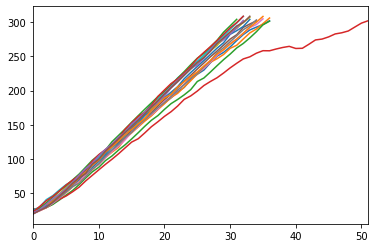

In [6]:
dfs = analysis.trial_dataframes

# Plot by epoch
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.episode_reward_mean.plot(ax=ax, legend=False)
    

In [7]:
analysis.dataframe().sort_values(['timesteps_total','episode_reward_mean'])[['config/lr', 
                                                                             'config/gamma', 
                                                                             'config/model', 
                                                                             'episode_reward_mean', 
                                                                             'timesteps_total']]


,config/lr,config/gamma,config/model,episode_reward_mean,timesteps_total
12,0.0003,0.990,"{'fcnet_hiddens': [128, 128]}",303.71,32000
4,0.0003,0.990,"{'fcnet_hiddens': [32, 32]}",300.09,33000
14,0.0001,0.990,"{'fcnet_hiddens': [128, 128]}",302.16,33000
9,0.0003,0.999,"{'fcnet_hiddens': [64, 64]}",308.01,33000
13,0.0003,0.999,"{'fcnet_hiddens': [128, 128]}",308.22,33000
10,0.0001,0.990,"{'fcnet_hiddens': [64, 64]}",303.64,34000
8,0.0003,0.990,"{'fcnet_hiddens': [64, 64]}",306.50,34000
15,0.0001,0.999,"{'fcnet_hiddens': [128, 128]}",308.21,34000
5,0.0003,0.999,"{'fcnet_hiddens': [32, 32]}",301.44,35000
7,0.0001,0.999,"{'fcnet_hiddens': [32, 32]}",302.86,35000


In [8]:
analysis.dataframe()[['config/lr', 'timesteps_total']].groupby('config/lr').mean()

,timesteps_total
config/lr,
0.0001,37125
0.0003,34250


In [9]:
analysis.dataframe()[['config/gamma', 'timesteps_total']].groupby('config/gamma').mean()

,timesteps_total
config/gamma,
0.990,34500
0.999,36875


In [10]:
aframe = analysis.dataframe()
aframe['config/model'] = aframe['config/model'].astype(str)
aframe[['config/model', 'timesteps_total']] \
    .groupby(['config/model']) \
    .mean() \
    .sort_values('timesteps_total') \
    .head(10)

,timesteps_total
config/model,
"{'fcnet_hiddens': [128, 128]}",33000
"{'fcnet_hiddens': [64, 64]}",34250
"{'fcnet_hiddens': [32, 32]}",34750
"{'fcnet_hiddens': [16, 16]}",40750


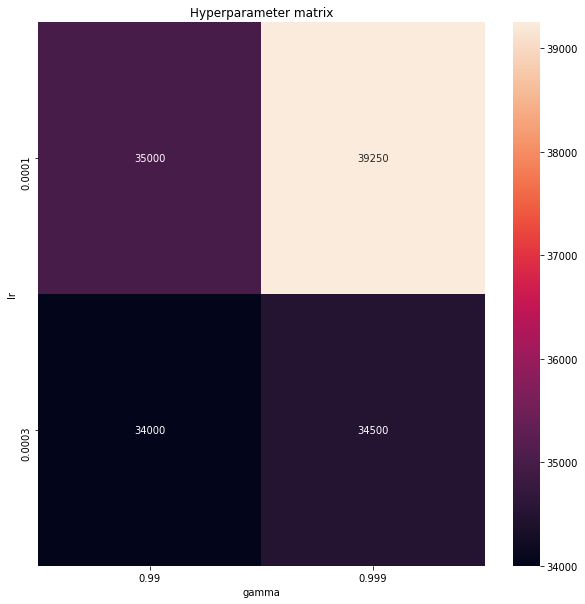

In [15]:
zframe = analysis.dataframe()[['config/lr', 'config/gamma', 'timesteps_total']]
matrix = pd.pivot_table(zframe, 
                        values='timesteps_total', 
                        index=['config/lr'], 
                        columns=['config/gamma'],
                        aggfunc=np.mean)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(matrix, annot=True, fmt='.0f')
plt.ylabel('lr')
plt.xlabel('gamma')
plt.title("Hyperparameter matrix")
plt.show()

In [16]:
logdir = analysis.get_best_logdir("timesteps_total", mode="min")
logdir

'/Users/druce/ray_results/cartpole_test/PPO_CartPole-v1_55716dc2_2020-02-24_08-12-39p91uxzxa'

In [19]:
with open('%s/params.json' % logdir) as f:
    data = json.load(f)
data

{'eager': False,
 'env': 'CartPole-v1',
 'gamma': 0.99,
 'lr': 0.0003,
 'model': {'fcnet_hiddens': [16, 16]},
 'num_gpus': 0,
 'num_workers': 1,
 'train_batch_size': 1000}

In [20]:
# train some more, saving checkpoint at end
ray.init(num_cpus=n_cpus, num_gpus=n_gpus, ignore_reinit_error=True, log_to_driver=False, webui_host='0.0.0.0')

ppo_config = {
    "env": env_name,
    "num_workers": n_cpus - 1,
    'model': {
        'fcnet_hiddens': [16, 16]
    },        
    'train_batch_size': 10000,
    "lr": 0.0003,
    'gamma': 0.99,
    "eager": False,
    'num_gpus': n_gpus  
}
                      
analysis = tune.run(
    "PPO",
    name='cartpole_test',
    verbose=1,

    stop={"episode_reward_mean": 500},  # stop when a parameter set is able to reach 500 timesteps
    config = ppo_config,
    checkpoint_freq=10,
    checkpoint_at_end=True,
    checkpoint_score_attr='episode_reward_mean',
    num_samples=1,  # for grid search, number of times to run each hyperparameter combo
    #     with_server=True,
    #     server_port=8267,
)


Trial name,status,loc,iter,total time (s),timesteps,reward
PPO_CartPole-v1_7f606ae2,TERMINATED,,15,99.3712,150000,500


2020-02-24 08:22:51,992	INFO tune.py:330 -- Returning an analysis object by default. You can call `analysis.trials` to retrieve a list of trials. This message will be removed in future versions of Tune.


In [21]:
list(analysis.trial_dataframes.keys())[0]


'/Users/druce/ray_results/cartpole_test/PPO_CartPole-v1_7f606ae2_2020-02-24_08-20-59b4bt028t'

In [23]:
!ls /Users/druce/ray_results/cartpole_test/PPO_CartPole-v1_7f606ae2_2020-02-24_08-20-59b4bt028t

checkpoint_10
checkpoint_15
events.out.tfevents.1582550485.MacDruce.local
params.json
params.pkl
progress.csv
result.json


In [24]:
# load last checkpoint for the runout
ckpoint = '/Users/druce/ray_results/cartpole_test/PPO_CartPole-v1_7f606ae2_2020-02-24_08-20-59b4bt028t/checkpoint_15/checkpoint-15'

trainer = PPOTrainer(config=ppo_config, env=env_name)
trainer.restore(ckpoint)


2020-02-24 08:24:04,086	WARNING util.py:41 -- Install gputil for GPU system monitoring.
2020-02-24 08:24:04,271	WARNING trainable.py:210 -- Getting current IP.
2020-02-24 08:24:04,275	INFO trainable.py:416 -- Restored on 192.168.0.35 from checkpoint: /Users/druce/ray_results/cartpole_test/PPO_CartPole-v1_7f606ae2_2020-02-24_08-20-59b4bt028t/checkpoint_15/checkpoint-15
2020-02-24 08:24:04,276	INFO trainable.py:423 -- Current state after restoring: {'_iteration': 15, '_timesteps_total': 150000, '_time_total': 99.37115359306335, '_episodes_total': 1024}


In [27]:
# view the runout

env = gym.make(env_name)
#env.seed(GLOBAL_SEED)

state = env.reset()
trainer.compute_action(state)

done = False

# run an episode
timestep = 0
r = 0
while not done:
    env.render()
    action = trainer.compute_action(state)
    state, reward, done, _ = env.step(action)
    r += reward
    timestep += 1
print(r)
env.close()
timestep

500.0


500